In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

## dataset description

In [27]:
ROOT_URL = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

def read_data(filename):
    data = np.loadtxt(ROOT_URL + filename, delimiter="\t")
    y = data[:,0].astype(int)
    x = data[:,1:]
    
    return x,y


xtr, ytr = read_data("FordA_TRAIN.tsv")
xts, yts = read_data("FordA_TEST.tsv")

print(xtr.shape, ytr.shape, xts.shape, yts.shape)

(3601, 500) (3601,) (1320, 500) (1320,)


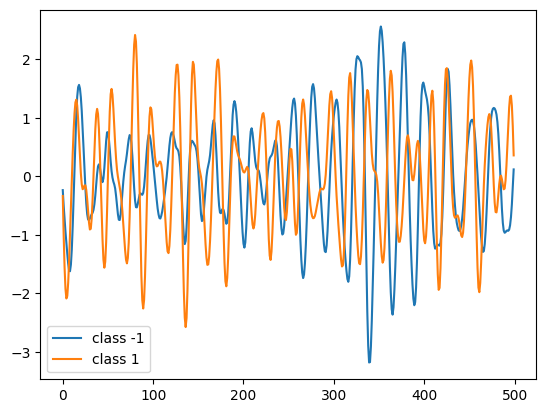

In [24]:
classes = np.unique(np.concatenate((ytr, yts)))

n = 2

for cl in classes:
    cl_data = xtr[ytr == cl]
    plt.plot(cl_data[n], label="class "+str(cl))
plt.legend()
plt.show()

In [28]:
# reshape into multivariate value
xtr = xtr.reshape((xtr.shape[0],xtr.shape[1],1))
xts = xts.reshape((xts.shape[0],xts.shape[1],1))
print(xtr.shape, xts.shape)

# shuffle
idx = np.random.permutation(xtr.shape[0])
xtr, ytr = xtr[idx], ytr[idx]

# labels tp positive ints
ytr[ytr == -1] = 0
yts[yts == -1] = 0


(3601, 500, 1) (1320, 500, 1)


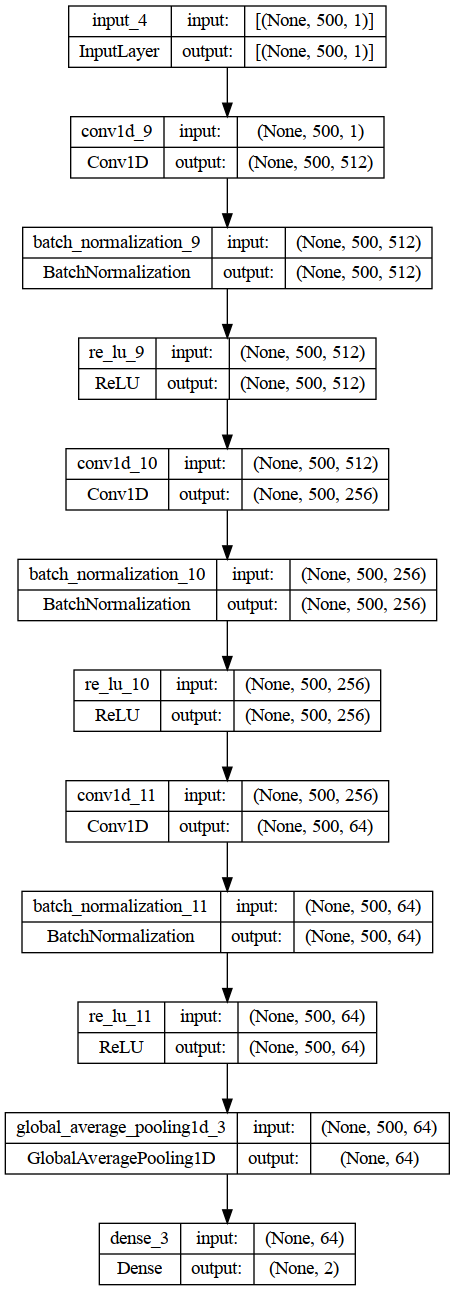

In [29]:
def build_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=512, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    ouput_layer = keras.layers.Dense(len(classes), activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=ouput_layer)

model = build_model(input_shape=xtr.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [31]:
epochs = 30
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

history = model.fit(
    xtr, ytr,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
90/90 [==============================] - 28s 294ms/step - loss: 0.3509 - sparse_categorical_accuracy: 0.8451 - val_loss: 0.4605 - val_sparse_categorical_accuracy: 0.7601 - lr: 0.0010
Epoch 2/30
90/90 [==============================] - 25s 279ms/step - loss: 0.3352 - sparse_categorical_accuracy: 0.8462 - val_loss: 0.6348 - val_sparse_categorical_accuracy: 0.6588 - lr: 0.0010
Epoch 3/30
90/90 [==============================] - 25s 278ms/step - loss: 0.3339 - sparse_categorical_accuracy: 0.8479 - val_loss: 0.3026 - val_sparse_categorical_accuracy: 0.8779 - lr: 0.0010
Epoch 4/30
90/90 [==============================] - 26s 288ms/step - loss: 0.3226 - sparse_categorical_accuracy: 0.8608 - val_loss: 0.2911 - val_sparse_categorical_accuracy: 0.8779 - lr: 0.0010
Epoch 5/30
90/90 [==============================] - 24s 264ms/step - loss: 0.3296 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.3908 - val_sparse_categorical_accuracy: 0.8003 - lr: 0.0010
Epoch 6/30
90/90 [============

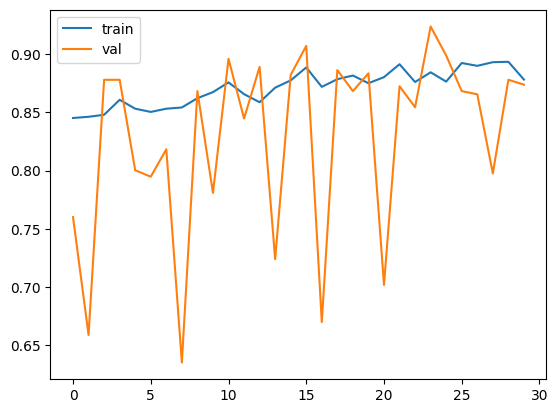

In [35]:
metric = "sparse_categorical_accuracy"
history.history.keys()
plt.plot(history.history[metric])
plt.plot(history.history["val_"+metric])
plt.legend(["train", "val"])
plt.show()